This notebook evaluates speed on a multi-attribute search task. 

We'll compare list comprehension, Pandas, SQLite, Dex, and FrozenDex. 

The results are:
 - list comprehension, filter, and Pandas take about **120ms**
 - SQLite (via LiteBox) takes about **12ms**
 - Dex takes takes **2ms** 
 - FrozenDex takes **1ms**

Dex and FrozenDex are the winners, by a long shot.

In [2]:
import random
from timeit import repeat
import pandas as pd

from functools import partial
from ducks import Dex, FrozenDex
from litebox import LiteBox

import seaborn as sns

#### Let's make 2 million fruits of different sizes, shapes, colors, and types.

In [3]:
types = ['apple', 'grape', 'mango', 'banana', 'watermelon']
colors = ['red', 'orange', 'yellow', 'green', 'blue']
shapes = ['cube', 'sphere', 'pyramid', 'dodecahedron']

random.seed(36)
fruits = [
    {
        'size': random.randint(1, 100),
        'type': random.choice(types),
        'color': random.choice(colors),
        'shape': random.choice(shapes)
    }
    for i in range(2_000_000)
]

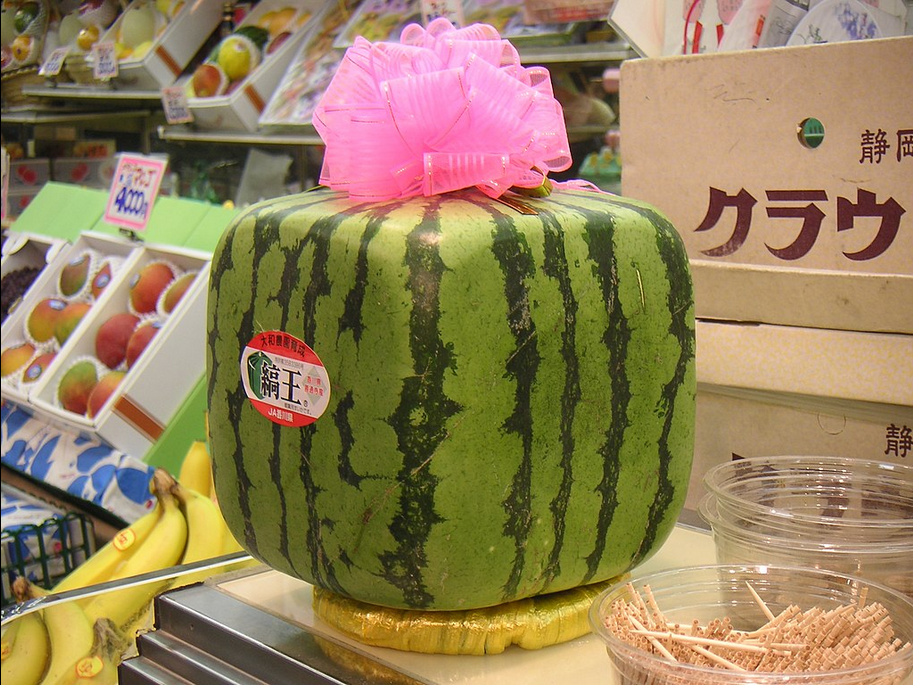

#### Goal: Find all the green cubic watermelons of size 50. 

In [4]:
# target properties
t_type='watermelon'
t_size=50
t_color='green'
t_shape='cube'

#### First, run each method and confirm it gives the correct number of results.

All methods should find the 200 fruits matching the criteria.

In [5]:
# List comprehension
def list_comprehension():
    return [f for f in fruits if f['type']==t_type and f['size']==t_size and f['color']==t_color and f['shape']==t_shape]

len(list_comprehension())

200

In [6]:
# Python filter
def python_filter():
    def f_matches(f):
        return f['type']==t_type and f['size']==t_size and f['color']==t_color and f['shape']==t_shape
    return list(filter(f_matches, fruits))

len(python_filter())

200

In [7]:
# Pandas
def pandas_query(df):
    df2 = df.query(f'index == {t_size}')
    return df2.query(f'color == "{t_color}" and shape == "{t_shape}" and type == "{t_type}"')

df = pd.DataFrame.from_records(fruits)
df = df.set_index('size')  # Index on the column with the most distinct values
len(pandas_query(df))

200

In [8]:
# LiteBox

# LiteBox uses SQLite as a BTree indexer for Python objects, but is otherwise very similar to ducks.
def litebox_find(lb):
    return lb.find(f'type == "{t_type}" and size == {t_size} and color == "{t_color}" and shape == "{t_shape}"')

lb = LiteBox(fruits, {'type': str, 'size': int, 'color': str, 'shape': str})
len(litebox_find(lb))

200

In [9]:
# Dex
def ducks_find(fb):
    return fb[{'type': t_type, 'size': t_size, 'color': t_color, 'shape': t_shape}]

dx = Dex(fruits, ['type', 'size', 'color', 'shape'])
len(ducks_find(dx))

200

In [10]:
# FrozenDex
def frozen_ducks_find(fdx):
    return fdx[{'type': t_type, 'size': t_size, 'color': t_color, 'shape': t_shape}]

fdx = FrozenDex(fruits, ['type', 'size', 'color', 'shape'])
len(frozen_ducks_find(fdx))

200

#### OK, everything looks correct. Let's do timings!

In [11]:
%%timeit 
list_comprehension()

115 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit 
python_filter()

163 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
pandas_query(df)

15.1 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
litebox_find(lb)

12.3 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
ducks_find(dx)

2.25 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
frozen_ducks_find(fdx)

1.11 ms ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Dex and FrozenDex are pretty quick! Let's make a chart.

In [17]:
def time_in_ms(f, n_times=10):
    t = min(repeat(f, number=n_times))/10
    return round(t*1000, 1)


In [18]:
results = {
    'filter': time_in_ms(python_filter),
    'list\ncomprehension': time_in_ms(list_comprehension),
    'pandas': time_in_ms(lambda: pandas_query(df)),
    'sqlite': time_in_ms(lambda: litebox_find(lb)),
    'Dex': time_in_ms(lambda: ducks_find(dx)),
    'FrozenDex': time_in_ms(lambda: frozen_ducks_find(fdx)),    
}

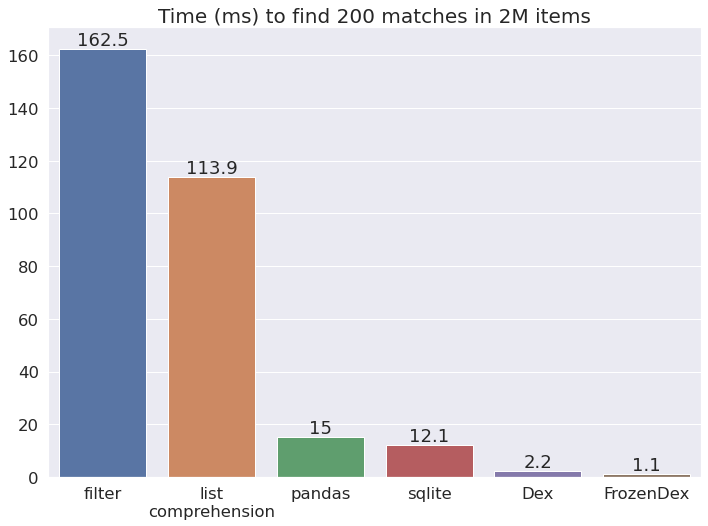

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
ax = sns.barplot(
    x=list(results.keys()),
    y=list(results.values())
)
ax.bar_label(ax.containers[0])
_ = ax.set_title('Time (ms) to find 200 matches in 2M items', fontsize=20)

## Discussion

Every benchmark comes with some assumptions. This benchmark is one that ducks can really win on! But obviously ducks is not the right choice for every possible situation. 

So let's specify what this benchmark is measuring, and look at some alternative situations, including ones where other methods match or even outperform ducks. 

### What assumptions are in this benchmark?

This benchmark is a good representation of where ducks can outperform. It is a query spanning multiple attributes, and each one is useful for narrowing down the results. 

If the benchmark only involved a single attribute, Dex and FrozenDex would still outperform, but less dramatically. Pandas and SQLite use essentially the same B-tree; the advantage of using ducks there is just that it has much lower overhead. 

The ducks approach to indexing is similar to the one used in Lucene / Solr / ElasticSearch family of datastores. So you can expect ducks performance to be similar to those. The primary difference is that ducks uses BTrees instead of hash-based lookups. So ducks is a bit stronger than them on range queries, and very slightly weaker on exact-value lookups versus those. The design choice difference is driven by expected dataset size. Ducks is unlikely to be used in cases with more than a billion objects, so traversing a BTree in log(1B) is not much worse than an O(1) hash lookup.

### What else could we use here?

#### Caching

Ducks does not do any kind of caching. To make ducks queries go even faster, you could use Python's `functools.lru_cache` decorator. This will speed up queries dramatically.

#### Dicts

If your query only involves exact matches, you could simply build a dict that maps a tuple of all attributes to the objects. Example: `{(size, type, color, shape): list_of_objects}`. Lookups would take nanoseconds. It's essentially the same as building a really big cache. 

The drawback would be flexibility. There's no good way to make a query involving `>` or `<` there, and no way to query a subset of attributes. 

#### Composite indexes

SQLite supports composite indexes, where a single index spans multiple attributes. In this example, SQLite is simply picking one index and ignoring the rest. But with a composite index, it can outperform ducks.

However, composite indexes come with a flexibility tradeoff. They will only support queries on exactly the columns they're built on - so a composite index on (A, B, C) will be useless when querying (B) or (C), and will be slower than ducks when querying (A, C). It's possible to use several composite indexes to cover the space of queries, but that strategy becomes worse as the number of columns increases.

If you know the exact queries you need to support, a composite index can get very good performance. 

Pandas also supports them: https://pandas.pydata.org/docs/user_guide/advanced.html

Eventually, it's likely that composite indexes will be added to ducks. They will look like this:

```
dex = Dex(objects, ['c', ('a', 'b', 'c')])
```
where 'c' is a single-attribute index and ('a', 'b', 'c') is a composite index. What's missing is a low-level composite BTree implementation that supports Python objects -- I haven't found or made one of those yet. If you have, please let me know!